In [ ]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install pandas scikit-learn matplotlib numpy graphviz statsmodels

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor

import graphviz
from sklearn.tree import export_graphviz
from IPython.display import Image

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Predicting baseball games

Using the data compiled from `baseball_data_collection.ipynb`, start training and testing the model. I will primarily be using the `RandomForestRegressor` model from scikit-learn, but other models are also shown for comparison purposes.

In [2]:
version = 6
df = pd.read_csv(f'../data/baseball/training/game_data_v{version}.csv')

### Processing the data

Split the game data for training and testing, either by seasons (2017-22 for training, 2023 for testing) or randomly. Also, drop any columns that should not be included in the model, such as team names.

In [3]:
# create the appropriate training and testing data based on home/away, dropping columns as needed
def create_data(drop_cols=['away_score', 'home_score', 'away_team', 'home_team'], y_col='away_score', split_by='random'):
    y = df[y_col]
    x = df.drop(drop_cols, axis=1)

    if split_by == 'season':
        x_train, x_test = x.iloc[0:13047], x.iloc[13047:]
        y_train, y_test = y.iloc[0:13047], y.iloc[13047:]
    else:
        x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True)
    
    return x_train, x_test, y_train, y_test

### Model analysis functions

Here are some helper functions for analyzing the model, including detailed visualizations and performance metrics.

In [4]:
# figure out which features (columns) are being considered most by the model
def get_feature_importances(cols, model):
    feature_importances = {
        'feature': [],
        'weight': []
    }
    
    for i in range(len(cols)):
        feature_importances['feature'].append(cols[i])
        feature_importances['weight'].append(f'{round(model.feature_importances_[i] * 100, 2)}%')
    
    return pd.DataFrame(feature_importances)

In [5]:
# visualizing decision trees
# https://www.datacamp.com/tutorial/random-forests-classifier-python
def visualize_decision_trees(model, cols, n_trees=1, max_depth=2):
    for i in range(n_trees):
        tree = model.estimators_[i]
        dot_data = export_graphviz(tree,
                                   feature_names=cols,  
                                   filled=True,  
                                   max_depth=max_depth, 
                                   impurity=False, 
                                   proportion=True)
        graph = graphviz.Source(dot_data)
        display(graph)

In [6]:
# get variance inflation factors for each feature - testing for multicollinearity
# https://www.datasklr.com/ols-least-squares-regression/multicollinearity
def get_vif(x):
    x_temp = sm.add_constant(x)

    vif = pd.DataFrame()
    vif['feature'] = x_temp.columns
    vif['variance_inflation_factor'] = [variance_inflation_factor(x_temp.values, i) for i in range(x_temp.values.shape[1])]
    
    return vif

In [7]:
# given a results dataframe, calculate the accuracy (in %) of the model in terms of predicting wins/losses
def wl_accuracy(results):
    num_correct = 0
    num_incorrect = 0
    
    for i in range(len(results)):
        game = results.iloc[i]
    
        pred_result = 1 if game['home_pred'] > game['away_pred'] else 0 # where 1 = home team wins
        actual_result = 1 if game['home_true'] > game['away_true'] else 0
        
        if pred_result == actual_result:
            num_correct += 1
        else:
            num_incorrect += 1

    return (num_correct / (num_correct + num_incorrect)) * 100

In [81]:
# calculate season records based on predictions
def season_record(results):
    team_records = {}

    for i in range(len(results)):
        away_team = df['away_team'].iloc[13047 + i]
        home_team = df['home_team'].iloc[13047 + i]
        home_team_won = results['away_pred'].iloc[i] <= results['home_pred'].iloc[i]
    
        if away_team not in team_records:
            team_records[away_team] = 0
    
        if home_team not in team_records:
            team_records[home_team] = 0
    
        team_records[away_team] += 1 if not home_team_won else 0
        team_records[home_team] += 1 if home_team_won else 0

    print('Season records:')
    count = 0
    
    for team in sorted(team_records, key=lambda x: team_records[x], reverse=True):
        count += 1
        print(f'{team}: {team_records[team]}-{162 - team_records[team]}', end='\t')
        
        if count % 5 == 0:
            print()

In [80]:
# calculate each team's runs scored per game based on predictions
def runs_per_game(results):
    runs_scored = {}

    for i in range(len(results)):
        away_team = df['away_team'].iloc[13047 + i]
        home_team = df['home_team'].iloc[13047 + i]
        
        if away_team not in runs_scored:
            runs_scored[away_team] = 0
    
        if home_team not in runs_scored:
            runs_scored[home_team] = 0

        runs_scored[away_team] += results['away_pred'].iloc[i]
        runs_scored[home_team] += results['home_pred'].iloc[i]

    print('Runs scored per game:')
    count = 0
    
    for team in sorted(runs_scored, key=lambda x: runs_scored[x], reverse=True):
        count += 1
        print(f'{team}: {round(runs_scored[team] / 162, 2)} ({round(runs_scored[team])})', end='\t')
        
        if count % 5 == 0:
            print()

## Random forest regressor

In [72]:
x_train_away, x_test_away, y_train_away, y_test_away = create_data(y_col='away_score', split_by='season')
x_train_home, x_test_home, y_train_home, y_test_home = create_data(y_col='home_score', split_by='season')

In [73]:
model_away = RandomForestRegressor(n_estimators=500, max_depth=5, max_features='sqrt')
model_home = RandomForestRegressor(n_estimators=500, max_depth=5, max_features='sqrt')

model_away.fit(x_train_away, y_train_away)
model_home.fit(x_train_home, y_train_home)

RandomForestRegressor(max_depth=5, max_features='sqrt', n_estimators=500)

In [74]:
pred_away = model_away.predict(x_test_away)
pred_home = model_home.predict(x_test_home)

results = pd.DataFrame({'away_pred': pred_away, 'home_pred': pred_home, 'away_true': y_test_away, 'home_true': y_test_home})
results.describe()

,away_pred,home_pred,away_true,home_true
count,2430.000000,2430.000000,2430.000000,2430.000000
mean,4.461088,4.599959,4.634979,4.596296
std,0.566250,0.474174,3.285711,3.150994
min,3.191907,3.361508,0.000000,0.000000
25%,4.049093,4.230516,2.000000,2.000000
50%,4.407612,4.557545,4.000000,4.000000
75%,4.848355,4.990735,6.000000,6.000000
max,6.860837,5.904489,25.000000,20.000000


In [75]:
print(f'Accuracy: {wl_accuracy(results)}%')

Accuracy: 58.14814814814815%


In [82]:
season_record(results)

Season records:
ATL: 157-5	LAD: 150-12	TB: 140-22	HOU: 135-27	TOR: 134-28	
PHI: 132-30	MIN: 127-35	SEA: 126-36	MIL: 120-42	SD: 115-47	
NYY: 109-53	SF: 107-55	TEX: 93-69	NYM: 92-70	CHC: 88-74	
BAL: 74-88	BOS: 70-92	MIA: 64-98	STL: 64-98	CLE: 62-100	
DET: 53-109	LAA: 44-118	CIN: 40-122	AZ: 40-122	CWS: 30-132	
KC: 27-135	PIT: 18-144	WSH: 11-151	COL: 7-155	OAK: 1-161	


In [83]:
runs_per_game(results)

Runs scored per game:
ATL: 5.26 (852)	LAD: 5.09 (825)	HOU: 4.92 (797)	TOR: 4.78 (775)	PHI: 4.77 (773)	
SD: 4.77 (772)	MIN: 4.73 (766)	SEA: 4.7 (762)	TB: 4.67 (757)	MIL: 4.67 (757)	
TEX: 4.64 (752)	NYY: 4.61 (747)	SF: 4.58 (742)	STL: 4.58 (742)	NYM: 4.57 (741)	
CHC: 4.57 (740)	BAL: 4.49 (727)	BOS: 4.45 (721)	CLE: 4.44 (719)	MIA: 4.43 (717)	
CIN: 4.42 (715)	LAA: 4.41 (714)	DET: 4.34 (704)	AZ: 4.29 (695)	KC: 4.24 (688)	
CWS: 4.22 (683)	PIT: 4.15 (673)	WSH: 4.07 (659)	COL: 4.06 (657)	OAK: 4.0 (647)	


A random forest regressor with 500 decision trees and a maximum depth of 5 produces an accuracy of about 58%. This is great - most other models have an accuracy ranging from 55% to 60%. However, when I combine all the predicted outcomes and print the aggregate (i.e. the season win-loss record), the results appear to be extremely skewed. The Oakland Athletics (OAK), for instance, are predicted to lose almost every single game of the season. This can be partly explained by the low standard deviation of predicted runs scored, and one way to increase the variance is to decrease the number of decision trees (the `n_estimators` parameter) in the forest.

## Increasing the variance

In [17]:
model_away = RandomForestRegressor(n_estimators=3, max_features='sqrt')
model_home = RandomForestRegressor(n_estimators=3, max_features='sqrt')

model_away.fit(x_train_away, y_train_away)
model_home.fit(x_train_home, y_train_home)

pred_away = model_away.predict(x_test_away)
pred_home = model_home.predict(x_test_home)

results = pd.DataFrame({'away_pred': pred_away, 'home_pred': pred_home, 'away_true': y_test_away, 'home_true': y_test_home})
results.describe()

print(f'Accuracy: {wl_accuracy(results)}%')
print('-' * 30)
season_record(results)
print('-' * 30)
runs_per_game(results)

Accuracy: 53.991769547325106%
------------------------------
Season records:
MIL: 98-64	CHC: 69-93	PIT: 44-118	CIN: 85-77	AZ: 74-88	
LAD: 94-68	NYM: 87-75	MIA: 77-85	COL: 35-127	SD: 90-72	
TOR: 94-68	STL: 82-80	ATL: 108-54	WSH: 41-121	BAL: 96-66	
BOS: 84-78	CWS: 59-103	HOU: 101-61	MIN: 101-61	KC: 48-114	
SF: 93-69	NYY: 87-75	LAA: 74-88	OAK: 50-112	CLE: 92-70	
SEA: 87-75	DET: 74-88	TB: 107-55	PHI: 108-54	TEX: 91-71	
------------------------------
Runs scored per game:
MIL: 4.63 (751)	CHC: 4.48 (725)	PIT: 4.02 (652)	CIN: 4.67 (757)	AZ: 4.57 (740)	
LAD: 4.76 (772)	NYM: 4.65 (753)	MIA: 4.43 (718)	COL: 4.05 (655)	SD: 5.15 (834)	
TOR: 4.84 (785)	STL: 4.65 (754)	ATL: 5.41 (876)	WSH: 3.76 (609)	BAL: 4.75 (769)	
BOS: 4.61 (747)	CWS: 3.94 (639)	HOU: 5.07 (821)	MIN: 5.03 (814)	KC: 4.3 (696)	
SF: 4.94 (801)	NYY: 4.59 (744)	LAA: 4.49 (727)	OAK: 4.1 (664)	CLE: 4.97 (806)	
SEA: 4.94 (800)	DET: 4.52 (732)	TB: 5.46 (884)	PHI: 4.84 (784)	TEX: 4.59 (743)	


By using fewer decision trees, the aggregate records came out to be more realistic - even if it did come at the cost of losing some accuracy. Looking at the histogram below, we can see that this modified version has a mean accuracy of about 53%, which is still better than a random guessing model.

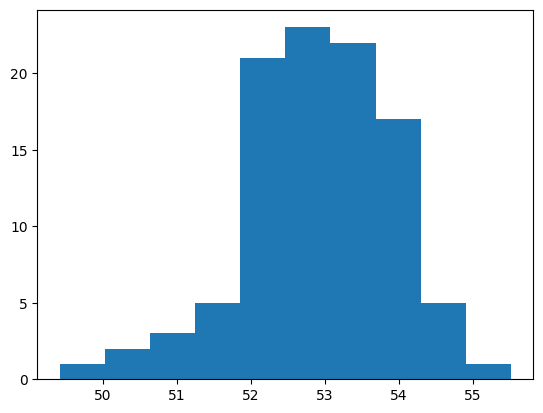

,0
count,100.000000
mean,52.913580
std,0.997203
min,49.423868
25%,52.386831
50%,52.942387
75%,53.580247
max,55.514403


In [18]:
acc = []

for i in range(100):
    model_away.fit(x_train_away, y_train_away)
    model_home.fit(x_train_home, y_train_home)
    
    pred_away = model_away.predict(x_test_away)
    pred_home = model_home.predict(x_test_home)
    
    results = pd.DataFrame({'away_pred': pred_away, 'home_pred': pred_home, 'away_true': y_test_away, 'home_true': y_test_home})
    results.describe()
    
    acc.append(wl_accuracy(results))

plt.hist(acc)
plt.show()

pd.DataFrame(acc).describe()

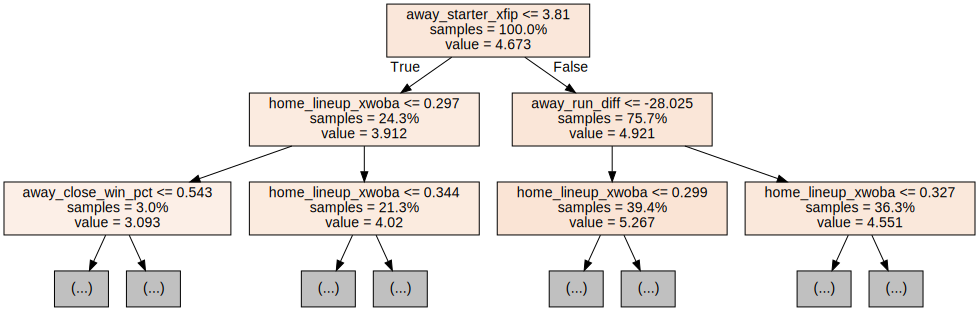

In [19]:
visualize_decision_trees(model_home, x_test_home.columns)

## Selecting features

There is another problem with this random forest model, though. The output below shows how much each column is weighted when making predictions for how many runs the home team will score. We can see that, for example, `home_starter_xfip` is weighted at about 12% - but does the home team's starting *pitcher* really have that much effect on the home team's *batting* results? I tried to fine-tune the model by removing unnecessary or irrelevant features.

In [20]:
get_feature_importances(x_test_home.columns, model_home)

,feature,weight
0,away_team_xwoba_diff,5.42%
1,away_lineup_xwoba,13.32%
2,away_team_xfip,5.9%
3,away_starter_xfip,12.87%
4,away_close_win_pct,5.7%
5,away_run_diff,5.9%
6,home_team_xwoba_diff,5.74%
7,home_lineup_xwoba,14.01%
8,home_team_xfip,5.98%
9,home_starter_xfip,12.49%


In [21]:
x_train_away, x_test_away, y_train_away, y_test_away = create_data(drop_cols=['away_score', 'home_score',
                                                                              'away_team', 'home_team',
                                                                              'away_team_xfip', 'away_starter_xfip',
                                                                              'home_lineup_xwoba', 'home_run_diff'],
                                                                   y_col='away_score',
                                                                   split_by='season')
x_train_home, x_test_home, y_train_home, y_test_home = create_data(drop_cols=['away_score', 'home_score',
                                                                              'away_team', 'home_team',
                                                                              'home_team_xfip', 'home_starter_xfip',
                                                                              'away_lineup_xwoba', 'away_run_diff'],
                                                                   y_col='home_score',
                                                                   split_by='season')

In [24]:
model_away = RandomForestRegressor(n_estimators=3, max_features='sqrt')
model_home = RandomForestRegressor(n_estimators=3, max_features='sqrt')

model_away.fit(x_train_away, y_train_away)
model_home.fit(x_train_home, y_train_home)

pred_away = model_away.predict(x_test_away)
pred_home = model_home.predict(x_test_home)

results = pd.DataFrame({'away_pred': pred_away, 'home_pred': pred_home, 'away_true': y_test_away, 'home_true': y_test_home})
results.describe()

print(f'Accuracy: {wl_accuracy(results)}%')

Accuracy: 53.20987654320988%


In [25]:
get_feature_importances(x_test_home.columns, model_home)

,feature,weight
0,away_team_xwoba_diff,9.39%
1,away_team_xfip,8.52%
2,away_starter_xfip,20.76%
3,away_close_win_pct,8.63%
4,home_team_xwoba_diff,8.77%
5,home_lineup_xwoba,25.03%
6,home_close_win_pct,9.31%
7,home_run_diff,9.59%


Now, `away_starter_xfip` and `home_lineup_xwoba` are weighted the most, which is more reasonable; the home team's lineup strength and the away team's starting pitcher should matter most when predicting the home team's runs scored.

## Testing for multicollinearity

At this point, my mentor has raised the question of a possible multicollinearity, where two or more features are correlated with each other. Indeed, some features had very high variance inflation factors. In particular, `home_team_xwoba_diff` had the highest VIF, which makes sense because *team* batting stats would generally be similar to the game's *lineup* batting stats.

In [80]:
ols_model = sm.OLS(y_train_home, sm.add_constant(x_train_home)).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:             home_score   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     71.97
Date:                Mon, 22 Jul 2024   Prob (F-statistic):          1.61e-116
Time:                        10:38:04   Log-Likelihood:                -33365.
No. Observations:               13047   AIC:                         6.675e+04
Df Residuals:                   13038   BIC:                         6.681e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -4.5704 

In [81]:
get_vif(x_train_home)

,feature,variance_inflation_factor
0,const,1236.384644
1,away_team_xwoba_diff,3.094334
2,away_team_xfip,3.203630
3,away_starter_xfip,1.449220
4,away_close_win_pct,1.353591
5,home_team_xwoba_diff,6.005394
6,home_lineup_xwoba,1.784004
7,home_close_win_pct,1.445171
8,home_run_diff,5.582397


After looking at the table above, I decided to remove the `home_team_xwoba_diff` and `home_run_diff` features, both of which had a VIF over 5, from the home team dataset. Similarly, I removed the `away_team_xwoba_diff` and `away_run_diff` features from the away team dataset.

In [53]:
x_train_away, x_test_away, y_train_away, y_test_away = create_data(drop_cols=['away_score', 'home_score',
                                                                              'away_team', 'home_team',
                                                                              'away_team_xfip', 'away_starter_xfip',
                                                                              'home_lineup_xwoba', 'home_run_diff',
                                                                              'away_team_xwoba_diff', 'away_run_diff'],
                                                                   y_col='away_score',
                                                                   split_by='season')
x_train_home, x_test_home, y_train_home, y_test_home = create_data(drop_cols=['away_score', 'home_score',
                                                                              'away_team', 'home_team',
                                                                              'home_team_xfip', 'home_starter_xfip',
                                                                              'away_lineup_xwoba', 'away_run_diff',
                                                                              'home_team_xwoba_diff', 'home_run_diff'],
                                                                   y_col='home_score',
                                                                   split_by='season')

In [40]:
model_away = RandomForestRegressor(n_estimators=3, max_features='sqrt')
model_home = RandomForestRegressor(n_estimators=3, max_features='sqrt')

model_away.fit(x_train_away, y_train_away)
model_home.fit(x_train_home, y_train_home)

pred_away = model_away.predict(x_test_away)
pred_home = model_home.predict(x_test_home)

results = pd.DataFrame({'away_pred': pred_away, 'home_pred': pred_home, 'away_true': y_test_away, 'home_true': y_test_home})
results.describe()

print(f'Accuracy: {wl_accuracy(results)}%')

Accuracy: 52.88065843621399%


In [41]:
get_feature_importances(x_test_home.columns, model_home)

,feature,weight
0,away_team_xwoba_diff,8.74%
1,away_team_xfip,9.28%
2,away_starter_xfip,22.48%
3,away_close_win_pct,9.55%
4,home_lineup_xwoba,30.34%
5,home_close_win_pct,19.62%


## Testing for specific cases

In [47]:
def enter_data(data_away, data_home,
               away_xwoba=0.000, away_team=4.00, away_starter=4.00, away_close=0.5, away_lineup=0.300,
               home_xwoba=0.000, home_team=4.00, home_starter=4.00, home_close=0.5, home_lineup=0.300):
    data_home['away_team_xwoba_diff'].append(away_xwoba)
    data_home['away_team_xfip'].append(away_team)
    data_home['away_starter_xfip'].append(away_starter)
    data_home['away_close_win_pct'].append(away_close)
    data_away['away_lineup_xwoba'].append(away_lineup)
    data_away['away_close_win_pct'].append(away_close)

    data_away['home_team_xwoba_diff'].append(home_xwoba)
    data_away['home_team_xfip'].append(home_team)
    data_away['home_starter_xfip'].append(home_starter)
    data_away['home_close_win_pct'].append(home_close)
    data_home['home_lineup_xwoba'].append(home_lineup)
    data_home['home_close_win_pct'].append(home_close)

In [63]:
test_data_away = {
    'away_lineup_xwoba': [],
    'away_close_win_pct': [],
    'home_team_xwoba_diff': [],
    'home_team_xfip': [],
    'home_starter_xfip': [],
    'home_close_win_pct': []
}

test_data_home = {
    'away_team_xwoba_diff': [],
    'away_team_xfip': [],
    'away_starter_xfip': [],
    'away_close_win_pct': [],
    'home_lineup_xwoba': [],
    'home_close_win_pct': []
}

# Game #1
# (away) good pitching and good hitting team vs. (home) bad pitching and bad hitting team
#  => should expect away team to win most of the time
enter_data(test_data_away, test_data_home, away_starter=2.50, away_lineup=0.450, home_starter=5.50, home_lineup=0.250)

# Game #2
# (away) bad pitching and bad pitching team vs. (home) good pitching and good hitting team
#  => should expect home team to win most of the time
enter_data(test_data_away, test_data_home, away_starter=5.50, away_lineup=0.250, home_starter=2.50, home_lineup=0.450)

# Game #3
# (away) good pitching and good hitting team vs. (home) average pitching and average hitting team
#  => should expect away team to win most of the time, but less extreme
enter_data(test_data_away, test_data_home, away_starter=2.50, away_lineup=0.450, home_starter=4.00, home_lineup=0.300)

# Game #4
# (away) good pitching and good hitting team vs. (home) good pitching and good hitting team
#  => should expect close to a 50-50 split
enter_data(test_data_away, test_data_home, away_starter=2.50, away_lineup=0.450, home_starter=2.50, home_lineup=0.450)

# Game #5
# (away) average pitching and average hitting team vs. (home) average pitching and average hitting team
#  => should expect close to a 50-50 split
enter_data(test_data_away, test_data_home, away_starter=4.00, away_lineup=0.300, home_starter=4.00, home_lineup=0.300)

# Game #6
# (away) slightly above average pitching and slightly below average hitting vs. (home) slightly below average pitching and slightly below average pitching
#  => should expect slight edge to away team
enter_data(test_data_away, test_data_home, away_starter=3.80, away_lineup=0.290, home_starter=4.60, home_lineup=0.410)
random

x_test_away = pd.DataFrame(test_data_away)
x_test_home = pd.DataFrame(test_data_home)

In [68]:
model_away = RandomForestRegressor(n_estimators=3, max_features='sqrt')
model_home = RandomForestRegressor(n_estimators=3, max_features='sqrt')

In [69]:
away_wins = []
home_wins = []
total_iter = 100

for i in range(len(x_test_away)):
    away_wins.append(0)
    home_wins.append(0)

for i in range(total_iter):
    model_away.fit(x_train_away, y_train_away)
    model_home.fit(x_train_home, y_train_home)
    
    pred_away = model_away.predict(x_test_away)
    pred_home = model_home.predict(x_test_home)

    for j in range(len(pred_away)):
        if pred_away[j] > pred_home[j]:
            away_wins[j] += 1
        else:
            home_wins[j] += 1

for i in range(len(away_wins)):
    print(f'Game #{i + 1}')
    print(f'Away: {away_wins[i]}-{total_iter - away_wins[i]}')
    print(f'Home: {home_wins[i]}-{total_iter - home_wins[i]}')
    print()

Game #1
Away: 79-21
Home: 21-79

Game #2
Away: 14-86
Home: 86-14

Game #3
Away: 72-28
Home: 28-72

Game #4
Away: 10-90
Home: 90-10

Game #5
Away: 28-72
Home: 72-28

Game #6
Away: 18-82
Home: 82-18



## Linear regression

In [54]:
model_away = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])
model_home = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])

model_away.fit(x_train_away, y_train_away)
model_home.fit(x_train_home, y_train_home)

pred_away = model_away.predict(x_test_away)
pred_home = model_home.predict(x_test_home)

results = pd.DataFrame({'away_pred': pred_away, 'home_pred': pred_home, 'away_true': y_test_away, 'home_true': y_test_home})
results.describe()

print(f'Accuracy: {wl_accuracy(results)}%')
print('-' * 30)
season_record(results)
print('-' * 30)
runs_per_game(results)

Accuracy: 58.2716049382716%
------------------------------
Season records:
MIL: 108-54	CHC: 87-75	PIT: 29-133	CIN: 52-110	AZ: 32-130	
LAD: 140-22	NYM: 96-66	MIA: 89-73	COL: 7-155	SD: 111-51	
TOR: 132-30	STL: 77-85	ATL: 151-11	WSH: 11-151	BAL: 77-85	
BOS: 83-79	CWS: 27-135	HOU: 121-41	MIN: 123-39	KC: 41-121	
SF: 112-50	NYY: 109-53	LAA: 64-98	OAK: 5-157	CLE: 50-112	
SEA: 117-45	DET: 58-104	TB: 100-62	PHI: 131-31	TEX: 90-72	
------------------------------
Runs scored per game:
MIL: 4.56 (739)	CHC: 4.64 (752)	PIT: 4.31 (698)	CIN: 4.48 (726)	AZ: 4.29 (696)	
LAD: 5.01 (812)	NYM: 4.62 (748)	MIA: 4.55 (736)	COL: 4.15 (672)	SD: 4.78 (775)	
TOR: 4.78 (774)	STL: 4.78 (775)	ATL: 5.33 (864)	WSH: 4.14 (671)	BAL: 4.59 (743)	
BOS: 4.5 (729)	CWS: 4.25 (689)	HOU: 4.87 (789)	MIN: 4.72 (764)	KC: 4.45 (722)	
SF: 4.53 (733)	NYY: 4.58 (743)	LAA: 4.56 (739)	OAK: 4.0 (648)	CLE: 4.36 (706)	
SEA: 4.71 (763)	DET: 4.43 (718)	TB: 4.41 (715)	PHI: 4.8 (777)	TEX: 4.62 (749)	


## Random guessing

Just out of curiousty :P

In [55]:
def generate_random_results():
    results = {'away_pred': [], 'home_pred': [], 'away_true': y_test_away, 'home_true': y_test_home}
    
    for i in range(len(y_test_away)):
        results['away_pred'].append(random.randint(0, 1))
        results['home_pred'].append(1 - results['away_pred'][i])
    
    return pd.DataFrame(results)

In [57]:
results = generate_random_results()
print(f'Accuracy: {wl_accuracy(results)}%')
print('-' * 30)
season_record(results)

Accuracy: 49.58847736625515%
------------------------------
Season records:
MIL: 76-86	CHC: 84-78	PIT: 81-81	CIN: 83-79	AZ: 91-71	
LAD: 88-74	NYM: 78-84	MIA: 79-83	COL: 72-90	SD: 84-78	
TOR: 85-77	STL: 75-87	ATL: 82-80	WSH: 70-92	BAL: 85-77	
BOS: 93-69	CWS: 81-81	HOU: 81-81	MIN: 84-78	KC: 78-84	
SF: 79-83	NYY: 80-82	LAA: 84-78	OAK: 85-77	CLE: 77-85	
SEA: 77-85	DET: 84-78	TB: 85-77	PHI: 83-79	TEX: 66-96	


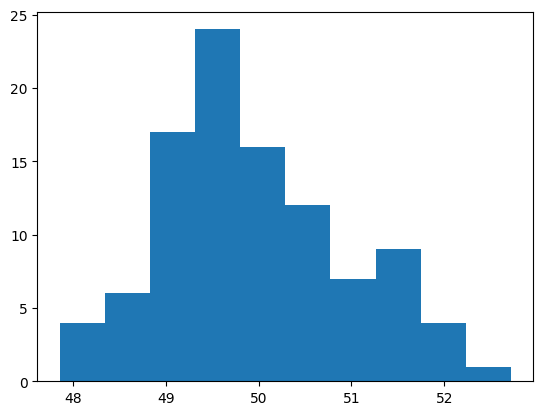

,0
count,100.000000
mean,49.965021
std,1.014860
min,47.860082
25%,49.290123
50%,49.794239
75%,50.586420
max,52.716049


In [58]:
acc = []

for i in range(100):
    results = generate_random_results()
    acc.append(wl_accuracy(results))

plt.hist(acc)
plt.show()

pd.DataFrame(acc).describe()

## Misc

In [24]:
model_cv = GridSearchCV(estimator=MultiOutputRegressor(RandomForestRegressor()),
                        param_grid={
                            'estimator__n_estimators': [],
                            'estimator__max_depth': [2, 4, 6, 8, 10],
                        },
                        # scoring={
                        #     'accuracy': make_scorer(wl_accuracy),
                        # },
                        # refit='accuracy',
                        cv=5)

Correlation coefficient (away team): r=0.21497074779894154
Correlation coefficient (home team): r=0.20828820312352855


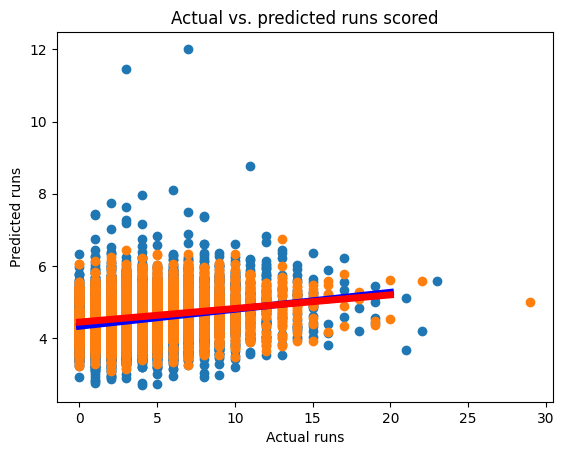

In [15]:
# drawing a scatterplot with regression line
# https://python-graph-gallery.com/scatterplot-with-regression-fit-in-matplotlib/

plt.scatter(y_test['away_score'], pred_df[0])
plt.scatter(y_test['home_score'], pred_df[1])


m_away, b_away = np.polyfit(y_test['away_score'], pred_df[0], deg=1)
x_away = np.linspace(0, 20, num=1000)

plt.plot(x_away, m_away * x_away + b_away, color='b', lw=5)

r_away = np.corrcoef(y_test['away_score'], pred_df[0])
print(f'Correlation coefficient (away team): r={r_away[0][1]}')


m_home, b_home = np.polyfit(y_test['home_score'], pred_df[1], deg=1)
x_home = np.linspace(0, 20, num=1000)

plt.plot(x_home, m_home * x_home + b_home, color='r', lw=5)

r_home = np.corrcoef(y_test['home_score'], pred_df[1])
print(f'Correlation coefficient (home team): r={r_home[0][1]}')


plt.xlabel('Actual runs')
plt.ylabel('Predicted runs')
plt.title('Actual vs. predicted runs scored')

plt.show()